In [1]:
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [3]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v33'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}

In [7]:
h = histStore.get(HistogramId("RechitsEnergy", clueParams, "data")).getHistogram(HistogramKind.COUNT)[{
    "beamEnergy" : hist.loc(300),
    "layer" : slice(None, None, sum),
    "pointType" : slice(None, None, sum),
}]

Hist(Regular(500, 0.002, 20, transform=log, name='rechits_energy_plotAxis', label='Rechits energy (GeV)'), storage=Double()) # Sum: 4407774.0

In [9]:
def getHistogram(beamEnergy, datatype):
    return histStore.get(HistogramId("RechitsEnergy", clueParams, datatype)).getHistogram(HistogramKind.COUNT)[{
        "beamEnergy" : hist.loc(beamEnergy),
        "layer" : slice(None, None, sum),
        "pointType" : slice(None, None, sum),
    }]

In [47]:
def addLumiLegend(main_ax, datatypes, beamEnergy):
    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    hep.cms.lumitext(f"$e^+$ {str(beamEnergy)} GeV", ax=main_ax)
    main_ax.legend()

def countHistogramToWeightHistogram(h:hist.Hist):
    """ Transform a count boost.histogram (ie Double storage type) to a Weight storage histogram, with weights=1 """
    w_h = hist.Hist(*h.axes, storage=hist.storage.Weight())
    w_h.view(flow=True).value, w_h.view(flow=True).variance = h.view(flow=True), h.view(flow=True)
    return w_h

def plot(hists:list[hist.Hist], datatypes:list[str], beamEnergy, logX=False, logY=False, xMax=None):
    # Normalize MC to data counts
    for i in range(len(datatypes)):
        if i == 0:
            count_data = hists[0].sum(flow=True)
        else:
            hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
    
    #fig = plt.Figure()
    fig = plt.figure()
    ax = fig.subplots()
    
    hep.histplot(hists, label=[datatypeToLegendMap[datatype] for datatype in datatypes], yerr=False, ax=ax)

    #ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    #ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    #ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    if logX:
        ax.set_xscale("log")
    if logY:
        ax.set_yscale("log")
    if xMax:
        ax.set_xlim(right=xMax)

    #ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.xaxis.get_major_formatter().set_scientific(False)
    ax.set_xlabel("Rechit energy (GeV)")
    ax.set_ylabel("Rechit count")

    addLumiLegend(ax, datatypes, beamEnergy)


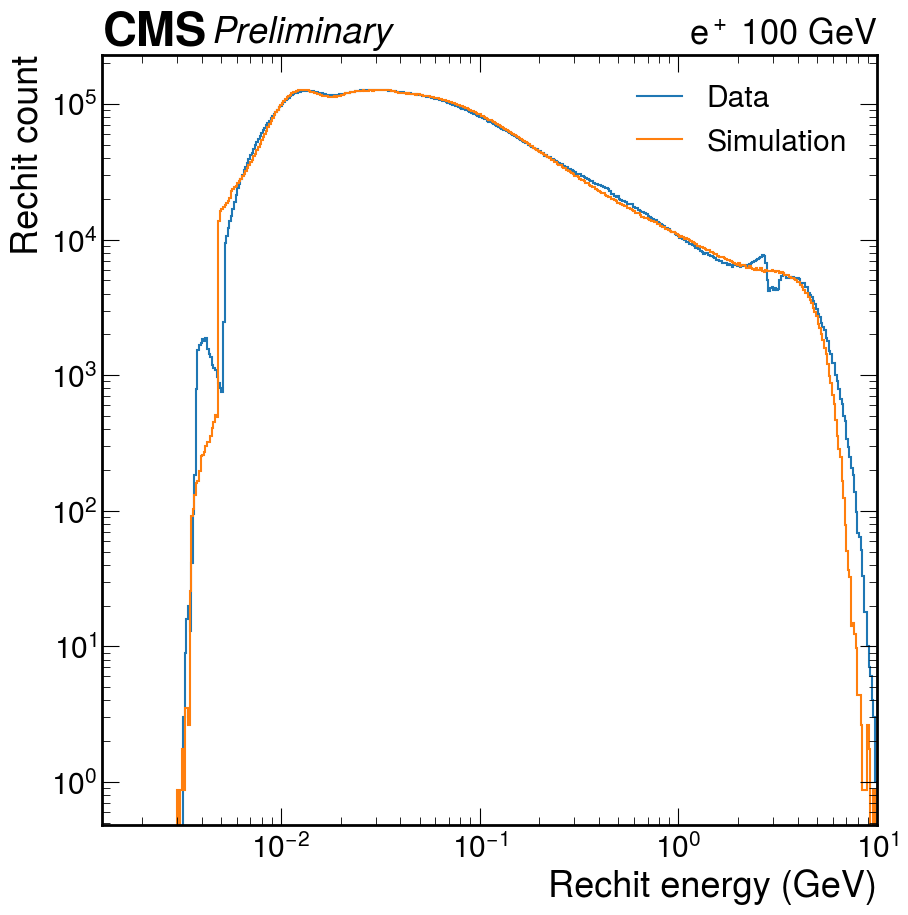

In [58]:
beamEnergy = 100
plot([getHistogram(beamEnergy, "data"), getHistogram(beamEnergy, "sim_proton_v46_patchMIP")], ["data", "sim_proton_v46_patchMIP"], 
    beamEnergy, logX=True, logY=True, xMax=10)